## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import random
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
#Keras (https://keras.io/api/metrics/)
#from tensorflow.keras import layers
#scikit-learn (https://scikit-learn.org/stable/)

from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from collections import deque


import tensorflow as tf

# 1. Pre-processing

## 1.1. Do some early processing of your metadata for easier model training:

### 1.1.1. add new column with the path to image

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
26211,00006875_030.png,No Finding,30,6875,58,F,PA,2562,2991,0.143,0.143,NaN,/data/images_004/images/00006875_030.png
101075,00026833_000.png,No Finding,0,26833,47,F,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026833_000.png
1087,00000265_005.png,No Finding,5,265,60,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000265_005.png


### 1.1.2. Add coumn for each decease from the 'Finding Labels' column

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases
## rather than working directly with the 'Finding Labels' column
##
finding_labels = set('|'.join(all_xray_df['Finding Labels']).split('|'))

for label in finding_labels:
  all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
#drop Findings label once decease has been split in different columns
all_xray_df = all_xray_df.drop(['Finding Labels'], axis=1)
#drop usless columm 
all_xray_df = all_xray_df.drop(['Unnamed: 11'],axis=1)

In [4]:
column_headers = all_xray_df.columns
column_headers

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'path', 'Fibrosis', 'Mass',
       'Nodule', 'Emphysema', 'Consolidation', 'Pneumonia', 'Cardiomegaly',
       'Edema', 'No Finding', 'Effusion', 'Pneumothorax', 'Atelectasis',
       'Hernia', 'Pleural_Thickening', 'Infiltration'],
      dtype='object')

### 1.1.3. Add a column with the number of decease per record

In [5]:
decease_columns = finding_labels.copy()
decease_columns.remove('No Finding')
all_xray_df['decease_number']=all_xray_df[decease_columns].sum(axis=1)

### Eliminate wrong input (age not possible) detected within the EDA phase 

In [6]:
all_xray_df = all_xray_df[all_xray_df['Patient Age']<120]

# 2. Case data splitting 

In [7]:
data_size = len(all_xray_df)

## 2.1. Get all normal cases

In [8]:
nodecease_df = all_xray_df[all_xray_df['No Finding']==1]
nodecease_data_size = len( nodecease_df)

## 2.2. Get deceased cases

In [9]:
decease_df = all_xray_df[all_xray_df['No Finding']==0]
decease_data_size = len(decease_df)

## 2.4. Get other decease cases without pneumonia

In [10]:
decease_wo_pneumonia_df = decease_df[decease_df.Pneumonia==0]
decease_wo_pneumonia_data_size = len(decease_wo_pneumonia_df)

## 2.5. Get pneumonia cases

In [11]:
decease_pneumonia_df= decease_df[decease_df.Pneumonia==1]
decease_pneumonia_data_size = len(decease_pneumonia_df)

### 2.5.1. Get pure pneumonial cases

In [12]:
pneumonia_pure_df= decease_pneumonia_df[decease_pneumonia_df.decease_number<2]
pneumonia_pure_data_size = len(pneumonia_pure_df)

### 2.5.2. Get pneumonia with other decease case

In [13]:
pneumonia_other_df = decease_pneumonia_df[decease_pneumonia_df.decease_number>1]
pneumonia_other_data_size = len(pneumonia_other_df)


In [14]:
print(f'Healthy cases                 : {nodecease_data_size}')
print(f'Decease cases                 : {decease_data_size}')
print(f'  Not pneumonia cases         :   {decease_wo_pneumonia_data_size}') 
print(f'  Pneumonia cases             :   {decease_pneumonia_data_size}')
print(f'    -Pure cases               :     {pneumonia_pure_data_size}')
print(f'    -With other deceases cases:     {pneumonia_other_data_size}')
print(f'Total cases                   : {data_size}' )      
      

Healthy cases                 : 60353
Decease cases                 : 51751
  Not pneumonia cases         :   50321
  Pneumonia cases             :   1430
    -Pure cases               :     322
    -With other deceases cases:     1108
Total cases                   : 112104


# 3. Create your training and testing data:

## 3.1. Strategy

We'll have 3 categories:

 - Negative (Healthy or other diseases) = 0
 - Pneumonia (with/without other deseases) = 1

Because of the relatively few case of pneumonia case (1430) , we will augment using **geometrical** transformation using Keras data generator to some extends to have at least a ratio of 1/10 of the healthy cases. Since we don't have acces to radiologist to label image and we were not successful to extract distinct patterns when analysing image pixels , we won't use custom augmmentation by blurring or somoothing images.  

On the other side we will tray to reduce by balancing not pneumonial case cross gender and age.

Once, this augmentation done , we will initializing a convolutional neural network (CNN) with class weights calculate with the following formulas:

weight_class_x = (1 / COUNT_CLASS_X) * (TOTAL_SAMPLES) / n

n= number of class
x = [1....n]

Note : due to technical no resolved issues in our environment, unfortunately we can't run all the generation in the same session at onces without the kernel beeing interupted will be interrupted  , we 'll generate each category separrately within files to prepare the training and testing phase


## 3.2. Set labels

In [15]:
#nodecease_df=nodecease_df.drop(columns=['category'])
#decease_wo_pneumonia_df=decease_wo_pneumonia_df.drop(columns=['category'])
#pneumonia_pure_df=pneumonia_pure_df.drop(columns=['category'])
#pneumonia_other_df=pneumonia_other_df.drop(columns=['category'])
#nodecease_df['category']

In [16]:
categories = ['NO_PNEUMONIA','PNEUMONIA'] 
nodecease_df=nodecease_df.copy()
nodecease_df.loc[:,'category']=categories[0] #'NO_DECEASE'
decease_wo_pneumonia_df= decease_wo_pneumonia_df.copy()
decease_wo_pneumonia_df.loc[:,'category']=categories[0] #'DECEASE_WO_PNEUMONIA'


pneumonia_pure_df = pneumonia_pure_df.copy()
pneumonia_pure_df.loc[:,'category']=categories[1]
pneumonia_other_df = pneumonia_other_df.copy()
pneumonia_other_df.loc[:,'category']=categories[1]
pneumonia_all_df= pd.concat([pneumonia_pure_df,pneumonia_other_df],ignore_index=True)
#shuffle
pneumonia_all_df = pneumonia_all_df.sample(frac=1).reset_index(drop=True)

#not rally nice code , but we have to merge the pneumonia case for technical issue when trainig 
#w_p_o = len(pneumonia_other_df)
#w_p_p = len(pneumonia_pure_df)

## 3.2. Data preparation

## 3.2.0. Helper's Functions and infrastructure


In [17]:
'''
Function to append file paths to a specific category and type of data in the dictionary

'''
def append_to_paths_dictonary(paths_dic, category, data_type, path):
    if category in paths_dic:
        if data_type in paths_dic[category]:
            print(f'append - {category}.{data_type}')
            paths_dic[category][data_type].append(path)
        else:
            print(f'new - {category}.{data_type}')
            paths_dic[category][data_type] = [path]
    else:
        paths_dic[category] = {data_type: [path]}
        
'''
Function to access the filepath in the paths_dict with the category and type of data as parameter
'''
def get_from_paths_dictonary(paths_dic,category,data_type):
    if category in paths_dic and data_type in paths_dic[category]:
        return paths_dic[category][data_type]
    else:
        return None
'''
Function to get all file paths from the dictionary
'''    
def get_all_paths_from_paths_dictonary(paths_dic):
    all_paths = []
    for category, types in paths_dic.items():
        for file_type, paths in types.items():
            all_paths.extend(paths)
    return all_paths    

def remove_directory(path):
    """
    Removes a directory and its contents.

    Parameters:
        path (str): Path to the directory to be removed.
    """
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' and its contents removed successfully.")
    except Exception as e:
        print(f"Error removing directory '{path}': {e}")

In [18]:
## Initialization procedure
import os

generated_root_dir = '/workspace/home/generated'

# Create the main directory
os.makedirs(generated_root_dir, exist_ok=True)

# Initialize an empty directory for generated paths for each category and type of data
generated_file_paths_dic = {}

#generate filepaths directory names
for category in categories:
    test_path = f'{generated_root_dir}/{category}/test'
    append_to_paths_dictonary(generated_file_paths_dic,category,'test',test_path)
    train_path = f'{generated_root_dir}/{category}/train'
    append_to_paths_dictonary(generated_file_paths_dic,category,'train',train_path)
    val_path = f'{generated_root_dir}/{category}/val'
    append_to_paths_dictonary(generated_file_paths_dic,category,'val',val_path)

    
    
paths_to_create = get_all_paths_from_paths_dictonary(generated_file_paths_dic)

# clean
for path  in paths_to_create:
    remove_directory(path)

# Create subdirectories
for path  in paths_to_create:
    os.makedirs(path, exist_ok=True)
    print(f"Directory '{path}' and its contents created successfully.")


new - NO_PNEUMONIA.train
new - NO_PNEUMONIA.val
new - PNEUMONIA.train
new - PNEUMONIA.val
Directory '/workspace/home/generated/NO_PNEUMONIA/test' and its contents removed successfully.
Directory '/workspace/home/generated/NO_PNEUMONIA/train' and its contents removed successfully.
Directory '/workspace/home/generated/NO_PNEUMONIA/val' and its contents removed successfully.
Directory '/workspace/home/generated/PNEUMONIA/test' and its contents removed successfully.
Directory '/workspace/home/generated/PNEUMONIA/train' and its contents removed successfully.
Directory '/workspace/home/generated/PNEUMONIA/val' and its contents removed successfully.
Directory '/workspace/home/generated/NO_PNEUMONIA/test' and its contents created successfully.
Directory '/workspace/home/generated/NO_PNEUMONIA/train' and its contents created successfully.
Directory '/workspace/home/generated/NO_PNEUMONIA/val' and its contents created successfully.
Directory '/workspace/home/generated/PNEUMONIA/test' and its con

In [19]:
#cleaning procedure
#cd /workspace/home/generated
%cd /workspace/home

#!rm r test
#!rm r train
#!ls

/workspace/home


## 3.2.1. Function for data augmentation generators definitions and mix of generators

In [20]:
#for batch in datagen.flow(x, batch_size=1, save_to_dir='path/to/save/augmented', save_prefix='aug', save_format='jpeg'):


In [21]:
# default no transformation


def make_generator(df,
                   directory,
                   rescale,
                   h_flip,
                   h_shift_range,
                   w_shift_range,
                   rotation_range,
                   shear_range,
                   zoom_range,
                   x_col,
                   y_col,
                   target_size,
                   batch_size,
                   classes,
                   class_mode = 'sparse'):
    print(f'batch size : {batch_size}')
    idg = ImageDataGenerator(rescale=rescale,
                             horizontal_flip = h_flip,
                             height_shift_range = h_shift_range,
                             width_shift_range = w_shift_range,
                             rotation_range = rotation_range,
                             shear_range = shear_range,
                             zoom_range = zoom_range)   
    print(f'{directory}')
    gen =idg.flow_from_dataframe(dataframe=df,
                                 directory=directory,
                                 x_col= x_col,
                                 y_col = y_col,
                                 classes=classes,
                                 class_mode = class_mode,
                                 target_size = target_size,
                                 batch_size=batch_size)

    return gen

def generate_images(df,
                   train_directory,
                   val_directory,
                   test_directory,
                   rescale, 
                   h_flip,
                   h_shift_range,
                   w_shift_range,
                   rotation_range,
                   shear_range,
                   zoom_range,
                   x_col,
                   y_col,
                   classes, 
                   factor, 
                   tgt_size, 
                   batch_size, 
                   ratio=0.8, 
                   seed =42): 
    '''
    Generate training adn test image generator
    Parameters:

    Return:
        train_generator,train_size,test_generator,test_size
    '''
    print(f'factor : {factor}')

    train_df = df.sample(frac=ratio,random_state = seed)
    left_df = df.drop(train_df.index).copy()
    val_df  = left_df.sample(frac=0.5,random_state = seed)
    test_df = left_df.drop(val_df.index)
    
    train_size = len(train_df)*factor//batch_size
    print(f'train size = {train_size} = {len(train_df)}*{factor}//{batch_size}')
                          
    #no factor apply for test and val 
    #val_size   = len(val_df)*factor
    val_size   = len(val_df)//batch_size
    #test_size = len(test_df)* factor
    test_size = len(test_df)//batch_size

    #val_batch_size = val_size//batch_size
    #val_test_size = test_size//batch_size
    #print(f'val_batch_size: {val_batch_size}')
    #print(f'val_test_size: {val_test_size}')

    if train_directory:
        train_generator = make_generator(df=train_df,
                                     directory=train_directory, 
                                     rescale=rescale,
                                     h_flip=h_flip,
                                     h_shift_range=h_shift_range,
                                     w_shift_range=w_shift_range,
                                     rotation_range=rotation_range,
                                     shear_range=shear_range,
                                     zoom_range=zoom_range,
                                     x_col=x_col,
                                     y_col=y_col,
                                     classes=classes,
                                     target_size = tgt_size, 
                                     batch_size = batch_size)
            
    if val_directory:
        val_generator = make_generator(df=val_df,
                                     directory=val_directory, 
                                     rescale=rescale,
                                     h_flip=False,
                                     h_shift_range=0,
                                     w_shift_range=0,
                                     rotation_range=0,
                                     shear_range=0,
                                     zoom_range=0,
                                     x_col=x_col,
                                     y_col=y_col,
                                     classes=classes,
                                     target_size = tgt_size, 
                                     batch_size = batch_size)
    if test_directory:
        test_generator = make_generator(df=test_df,
                                    directory=test_directory,
                                    rescale=rescale,
                                    h_flip=False,
                                    h_shift_range=0,
                                    w_shift_range=0,
                                    rotation_range=0,
                                    shear_range=0,
                                    zoom_range=0,
                                    x_col=x_col,
                                    y_col=y_col,
                                    classes=classes,
                                    target_size = tgt_size, 
                                    batch_size = batch_size )                  
    
    
    return train_generator,train_size,val_generator,val_size,test_generator,test_size
    '''
    keep code for usage
    print(f'Generate {train_size} train sample')
    while len(train_Xs)< train_size:
        X,Y =  train_generator.next()
        b_size = X.shape[0]
        for i in range(b_size):
            train_Xs.append(X[i,:,:,0])
            train_Ys.append(Y[i])
                      
    print(f'Generate {test_size} test sample')
    while len(test_Xs)< test_size:
        X,Y = test_generator.next()
        b_size = X.shape[0]
        for i in range(b_size):    
            test_Xs.append(X[i,:,:,0])
            #test_Ys.append(Y[i,:]) for generacity voi class_mode 
            test_Ys.append(Y[i])
    return train_Xs, train_Ys,test_Xs,test_Ys
    '''

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import threading



class MixedImageDataGenerator(object):
    """
    Wrapper class that mixes data from multiple ImageDataGenerator instances.

    Args:
        generators (list): List of ImageDataGenerator objects.
        limits (list): List of integers representing the number of batches
                        to be generated from each generator before switching.
        generator_type: type of generato 0 = train, 1 = validate , 2 = test                

    Attributes:
        generators (list): List of ImageDataGenerator objects.
        limits (list): List of integers representing batch limits.
        current_generator_index (int): Index of the currently active generator.
        remaining_batches (list): List of integers representing remaining
                                  batches per generator.
        data_queue (deque): Queue to store generated batches (optional for efficiency).
    """
    TYPE = ['train','validate','test']
    TRAIN =  0
    VALIDATE = 1
    TEST = 2
    
    def __init__(self, generators, limits,generator_type,debug=False):
        self.lock = threading.Lock()
        self.generators = generators
        self.limits = limits
        self.current_generator_index = 0
        self.remaining_batches = limits.copy()  # Directly assign the limits list
        self.debug=debug
        if self.debug:
            print(f'Create Generator :{MixedImageDataGenerator.TYPE[generator_type]}')
        self.generator_type = generator_type
    def get_step_number(self):
        return sum(self.limits)
    def get_remaining_batches(self):
        return sum(self.remaining_batches)
    
    def getType(self):
        return self.generator_type
    
    def get_generator_number(self):
        return(len(self.generators))
    
    def __iter__(self):
        """
        Makes the MixedImageDataGenerator object iterable,
        allowing it to be used in a for loop.

        Returns:
            self: The MixedImageDataGenerator object itself.
        """ 
        if  self.get_remaining_batches() == 0:
            return self.repeat()
        else:
            return self


    def __next__(self):
        """
        Returns the next batch of data from the mixed generators.

        Raises:
            StopIteration: If all limits have been exhausted.
        """
        if self.debug:
            print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]: next called [pre lock]')
        with self.lock:
            #if self.debug:
            print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]: next call ...')
            while True:
                #print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]Remaining batch:  {self.remaining_batches} limits: {self.limits}')
                if sum(self.remaining_batches) <= 0:
                    #if self.debug:
                    print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}] all limits exhausted')
                    raise StopIteration
                
                data = None
                while data is None:
                    # Check if current generator has remaining batches
                    if self.remaining_batches[self.current_generator_index] > 0:
                        # Ensure the current generator is advanced if its queue is empty
                        data = self.generators[self.current_generator_index].next() 
                        # Decrease the remaining batches of the current generator
                        self.remaining_batches[self.current_generator_index] -= 1
                        if self.debug:
                            print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]Remaining batch:  {self.remaining_batches} limits: {self.limits}')

                        
                    # Move to the next generator
                    self.current_generator_index = (self.current_generator_index + 1) % len(self.generators)
                    # If all generators have exhausted their limits, raise StopIteration
                    if all(remaining_batch <= 0 for remaining_batch in self.remaining_batches):
                        if self.debug:
                            print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}] all step data generated')
                        raise StopIteration
                if self.debug:
                    print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]: RETURN {type(data)}')
                print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}]: next called')
                return data

                
    def refresh(self, argument=None):      
        with self.lock:
            if self.debug:
                print(f'[{MixedImageDataGenerator.TYPE[self.generator_type]}] refresh')
            self.current_generator_index = 0
            self.remaining_batches = self.limits.copy()  # Directly assign the limits list
            # self.data_queue = deque(maxlen=10)  # Optional queue for efficiency

    def repeat(self):
        print('repeat called')
        while True:
            try:
                yield next(self)
            except StopIteration:
                self.refresh()       

In [23]:
from tensorflow.keras.callbacks import Callback


class MixedImageDataGeneratorRefresherCallBack(Callback):
    '''
    Call back function to renitialize the generators for each epochs call internaly by fit_generator function
    
    Usage 
    
    history = my_model.fit_generator(train_gen, steps_per_epoch=total_batches, epochs=num_epochs, callbacks=[callback])    
    '''
    def __init__(self, generators):
        self.generators = generators
        
    def on_train_begin(self, logs=None):
        print(f'[ON_TRAIN_BEGIN]')

        # first the refresh for because of pretest done within fit method
        #for i in range(len(self.generators)):
        #    print(f'[ON_TRAIN_BEGIN] refresh generator {i}')
        #    self.generators[i].refresh()
    def on_train_end(self, logs=None):
        print(f'[ON_TRAIN_END]')

    def on_batch_begin(self, batch, logs=None):
        print(f'[ON_BATCH_BEGIN] batch {batch}')

    def on_batch_end(self, batch, logs=None):
        print(f'[ON_BATCH_END] batch {batch}')

    def on_epoch_begin(self, epoch, logs=None):
        print(f'[ON_EPOCH_BEGIN] epoch {epoch}')
        #refresh generators before epochs
        for i in range(len(self.generators)):
            #if self.generators[i].getType() ==MixedImageDataGenerator.TRAIN:
            print(f'[ON_EPOCH_BEGIN] refresh generator {i} epoch {epoch}')
            self.generators[i].refresh()
    
    def on_epoch_end(self, epoch, logs=None):
        print(f'[ON_EPOCH_END] epoch {epoch}')


    def on_test_begin(self,logs=None):
        print(f'[ON_TEST_BEGIN]')
        #for i in range(len(self.generators)):
            #if self.generators[i].getType() ==MixedImageDataGenerator.VALIDATE:
            #    print(f'[ON_TEST_BEGIN] refresh generator {i} - {MixedImageDataGenerator.VALIDATE}')
            #    self.generators[i].refresh()    
    
    def on_test_end(self,logs=None):
        print(f'[ON_TEST_END]')


## 3.2.2. Augmententation of minority data by factor 10  

### 3.2.2.0 Parameters intialisation

In [24]:
rescale= 1/255
h_flip=True
h_shift_range=0.1
w_shift_range=0.1
rotation_range=5
shear_range=0
zoom_range=0

x_col = 'path'
y_col = 'category'
factor = 10
#factor = 10

## for VGG16
#classes= ['NO_DECEASE','DECEASE_WO_PNEUMONIA','PNEUMONIA_PURE_DECEASE','PNEUMONIA_OTHER_DECEASE']
#tgt_size = (224,224)
tgt_size = (299,299)
#batch_size = 1
#batch_size = 2*20
batch_size = 2*20

### 3.2.2.1 Augmentation pure pneumonia cases generators

In [25]:
#categories = ['NO_DECEASE','DECEASE_WO_PNEUMONIA','PNEUMONIA_PURE_DECEASE','PNEUMONIA_OTHER_DECEASE'] 
#phase removed we merge all the case to avoid trainig interuption 
'''
train_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'train')[0]
val_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'val')[0]
test_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'test')[0]
'''

"\ntrain_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'train')[0]\nval_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'val')[0]\ntest_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[4],'test')[0]\n"

In [26]:
'''
gen_p_p_train,gen_p_p_train_size,gen_p_p_val,gen_p_p_val_size,gen_p_p_test,gen_p_p_test_size = generate_images(df=pneumonia_all_df,
                                                       train_directory= train_directory,
                                                       val_directory = val_directory,
                                                       test_directory = test_directory,
                                                              rescale=rescale,
                                                              h_flip=h_flip,
                                                              h_shift_range = h_shift_range,
                                                              w_shift_range = w_shift_range,
                                                              rotation_range= rotation_range,
                                                              shear_range= shear_range,
                                                              zoom_range=zoom_range,
                                                              x_col=x_col,
                                                              y_col=y_col,
                                                              classes = categories,
                                                              factor=factor,
                                                              tgt_size=tgt_size,
                                                              batch_size=batch_size)
'''                                                              

'\ngen_p_p_train,gen_p_p_train_size,gen_p_p_val,gen_p_p_val_size,gen_p_p_test,gen_p_p_test_size = generate_images(df=pneumonia_all_df,\n                                                       train_directory= train_directory,\n                                                       val_directory = val_directory,\n                                                       test_directory = test_directory,\n                                                              rescale=rescale,\n                                                              h_flip=h_flip,\n                                                              h_shift_range = h_shift_range,\n                                                              w_shift_range = w_shift_range,\n                                                              rotation_range= rotation_range,\n                                                              shear_range= shear_range,\n                                                              zoom_r

### 3.2.2.2 Augmentation pneumonia with other decease cases generators

In [27]:
## set up GPU configuration
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#print(tf.config.list_physical_devices())

In [28]:
#Due to memmory problem split reduce to 7
#categories = ['NO_DECEASE','DECEASE_WO_PNEUMONIA',PNEUMONIA_AND_DECEASE'] 
train_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[1],'train')[0]
val_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[1],'val')[0]
test_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[1],'test')[0]

gen_p_train,gen_p_train_size,gen_p_val,gen_p_val_size,gen_p_test,gen_p_test_size = generate_images(df=pneumonia_all_df,
                                                       train_directory= train_directory,
                                                       val_directory=val_directory,
                                                       test_directory = test_directory,
                                                                rescale = rescale,
                                                                h_flip=h_flip,
                                                                h_shift_range = h_shift_range,
                                                                w_shift_range = w_shift_range,
                                                                rotation_range= rotation_range,
                                                                shear_range= shear_range,
                                                                zoom_range=zoom_range,
                                                                x_col=x_col,
                                                                y_col=y_col,
                                                                classes=categories,
                                                                factor=factor,
                                                                tgt_size=tgt_size,
                                                                batch_size=batch_size)
#set back the CPU



factor : 10
train size = 286 = 1144*10//40
batch size : 40
/workspace/home/generated/PNEUMONIA/train
Found 1144 validated image filenames belonging to 2 classes.
batch size : 40
/workspace/home/generated/PNEUMONIA/val
Found 143 validated image filenames belonging to 2 classes.
batch size : 40
/workspace/home/generated/PNEUMONIA/test
Found 143 validated image filenames belonging to 2 classes.


In [29]:
#set back CPU
#physical_devices = tf.config.list_physical_device('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], False)

## 3.2.3.Balance and generate of other decease and healthy cases

### 3.2.3.1 Function for data balancing

In [30]:
# Example usage:
# Replace 'your_dataset.csv' with your dataset file path and specify the column names and total_rows_to_select.
# balanced_data = balance_dataset(df, ['age', 'gender'], 100)
def select_balanced_dataset(df, column_names, total_rows_to_select):
    # Calculate the total number of rows you want to select
    num_groups = df.groupby(column_names).size().shape[0]
    min_records_per_group = total_rows_to_select // num_groups
    # Initialize an empty DataFrame to store the sampled rows
    balanced_df = pd.DataFrame(columns=df.columns)
    selected_indexes = []
    groupes_count = {}
    # Randomly sample from each group
    for _, group in df.groupby(column_names):
        count = group.shape[0]
        if count >= min_records_per_group:
            # If the group has enough records, sample the required number
            sample = group.sample(min_records_per_group, random_state=42)
        else:
            # If the group has fewer records than required, sample all of them
            sample = group    
        # Add the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sample])

        #store the index
        selected_indexes.extend(sample.index)
        
    # If you want a completely random subset, shuffle the resulting DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42)

    return balanced_df , selected_indexes

### 3.2.3.2. Balanced selection of other than pneumonia desease cases

Pickup  ~ 2 * generated pneumonia ( ~10000 training case and 3000 test case) ->  25000 cases

In [31]:
decease_wo_pneumonia_df['category']

0         NO_PNEUMONIA
1         NO_PNEUMONIA
2         NO_PNEUMONIA
4         NO_PNEUMONIA
5         NO_PNEUMONIA
              ...     
112096    NO_PNEUMONIA
112097    NO_PNEUMONIA
112100    NO_PNEUMONIA
112106    NO_PNEUMONIA
112108    NO_PNEUMONIA
Name: category, Length: 50321, dtype: object

In [32]:
selection_number = 20000
#Due to memmory problem split reduce to 7
#selection_number=20000
#selection_number=10000

balanced_decease_wo_pneumonia_df,selected_index = select_balanced_dataset(decease_wo_pneumonia_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)

In [33]:
len(balanced_decease_wo_pneumonia_df)

15818

In [34]:
balanced_decease_wo_pneumonia_df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Edema,No Finding,Effusion,Pneumothorax,Atelectasis,Hernia,Pleural_Thickening,Infiltration,decease_number,category
27344,00007120_004.png,4,7120,51,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,0,1,0,1,NO_PNEUMONIA
81302,00019967_020.png,20,19967,6,M,AP,2544,3056,0.139,0.139,...,0,0,0,0,1,0,0,1,2,NO_PNEUMONIA
7386,00001946_031.png,31,1946,19,M,AP,2896,2544,0.139,0.139,...,0,0,0,0,0,0,0,1,1,NO_PNEUMONIA
70747,00017446_002.png,2,17446,41,F,PA,2866,2621,0.143,0.143,...,0,0,1,0,0,0,0,0,1,NO_PNEUMONIA
49940,00012643_002.png,2,12643,70,F,AP,2500,2048,0.168,0.168,...,0,0,1,0,1,0,0,0,2,NO_PNEUMONIA


Check if balanced cross Gender,age and view postion

(array([7779.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8039.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

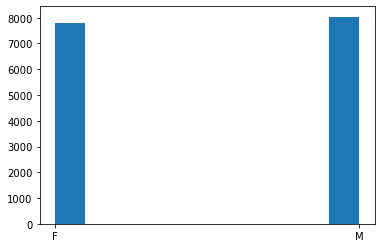

In [35]:
plt.hist(balanced_decease_wo_pneumonia_df['Patient Gender'])

(array([ 624., 1548., 1980., 2200., 1980., 1980., 2200., 1965., 1157.,
         184.]),
 array([1.0, 10.3, 19.6, 28.900000000000002, 38.2, 47.5,
        56.800000000000004, 66.10000000000001, 75.4, 84.7, 94.0],
       dtype=object),
 <a list of 10 Patch objects>)

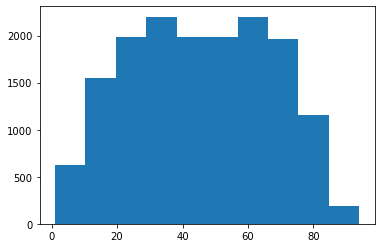

In [36]:
plt.hist(balanced_decease_wo_pneumonia_df['Patient Age'])

**Note:** there to few sample for age < 20 and >=80 to have a perfect equal rebalancing

(array([7822.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7996.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

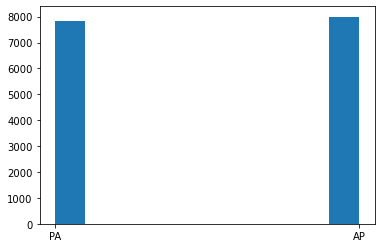

In [37]:
plt.hist(balanced_decease_wo_pneumonia_df['View Position'])

### 3.2.3.3. Balanced selection of healthy cases

In [38]:
#Due to memmory problem split reduce to 7
selection_number=20000
#selection_number=10000

balanced_nodecease_df,selected_index = select_balanced_dataset(nodecease_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)

In [39]:
#Pickup  ~ 2 * generated pneumonia ( ~10000 taraining case and 3000 test case) ->  25000 cases

len(balanced_nodecease_df)

15964

In [40]:
no_pneumonia_all_df= pd.concat([balanced_nodecease_df,balanced_decease_wo_pneumonia_df],ignore_index=True)
#shuffle
no_pneumonia_all_df = no_pneumonia_all_df.sample(frac=1).reset_index(drop=True)
print(len(no_pneumonia_all_df))

31782


### 3.2.3.3. Initialize parameter for images generation 

In [41]:
rescale= 1/255
h_flip=False
h_shift_range=0
w_shift_range=0
rotation_range=0
shear_range=0
zoom_range=0

x_col = 'path'
y_col = 'category'
factor = 1
## for VGG16
#tgt_size = (224,224)
#tgt_size = (299,299)
#batch_size = 1
#batch_size = 2*22
batch_size = 2*2*22


In [42]:
#categories = ['NO_DECEASE','DECEASE_WO_PNEUMONIA','PNEUMONIA_PURE_DECEASE','PNEUMONIA_OTHER_DECEASE'] 
train_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[0],'train')[0]
val_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[0],'val')[0]
test_directory = get_from_paths_dictonary(generated_file_paths_dic,categories[0],'test')[0]

In [43]:
gen_o_train,gen_o_train_size,gen_o_val,gen_o_val_size,gen_o_test,gen_o_test_size = generate_images(df=no_pneumonia_all_df,
                                                       train_directory= train_directory,
                                                       val_directory = val_directory,
                                                       test_directory = test_directory,
                                                      rescale = rescale,
                                                      h_flip=h_flip,
                                                      h_shift_range = h_shift_range,
                                                      w_shift_range = w_shift_range,
                                                      rotation_range= rotation_range,
                                                      shear_range= shear_range,
                                                      zoom_range=zoom_range,
                                                      x_col=x_col,
                                                      y_col=y_col,
                                                      classes=categories,
                                                      factor=factor,
                                                      tgt_size=tgt_size,
                                                      batch_size=batch_size)

factor : 1
train size = 288 = 25426*1//88
batch size : 88
/workspace/home/generated/NO_PNEUMONIA/train
Found 25426 validated image filenames belonging to 2 classes.
batch size : 88
/workspace/home/generated/NO_PNEUMONIA/val
Found 3178 validated image filenames belonging to 2 classes.
batch size : 88
/workspace/home/generated/NO_PNEUMONIA/test
Found 3178 validated image filenames belonging to 2 classes.


we won't complete with random data to 25000 cases

In [44]:
### 3.2.3.4. generate other than pneumonia iamges

In [45]:
#set back the CPU configuration
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], False)

## 3.2.3. Preparation of mixed generator  

In [69]:
'''
Original data 
healthy cases                 : 60353
Decease cases                 : 51751
  Not pneumonia cases         :   50321
  Pneumonia cases             :   1430
    -Pure cases               :     322
    -With other deceases cases:     1108
Total cases  
'''
'''
generator
gen_p_o_train,gen_p_o_train_size,gen_p_o_test,gen_p_o_test_size
gen_p_p_train,gen_p_p_train_size,gen_p_p_test,gen_p_p_test_size
gen_o_train,gen_o_train_size,gen_o_test,gen_o_test_size
gen_h_train,gen_h_train_size,gen_h_test,gen_h_test_size 
'''

mini =True
#mini =False

print('Training data setup:')

print(f'Generator for category: {categories[1]} training size: {gen_p_train_size}, val size: {gen_p_val_size}, test size: {gen_p_test_size}')
print(f'Generator for category: {categories[0]} training size: {gen_o_train_size}, val size: {gen_o_val_size}, test size: {gen_o_test_size}')



#train_gen = MixedImageDataGenerator([gen_p_o_train, gen_p_p_train,gen_o_train,gen_h_train],
#                                        [gen_p_o_train_size, gen_p_p_train_size,gen_o_train_size,gen_h_train_size])




train_generators =[gen_o_train,gen_p_train]
train_limits =  [gen_o_train_size,gen_p_train_size]
print(f'train_limits {train_limits}')

#mini_train_limits = [80,80,80]
mini_train_limits = [10,10]
train_gen = MixedImageDataGenerator(train_generators,train_limits,MixedImageDataGenerator.TRAIN)

mini_train_gen = MixedImageDataGenerator(train_generators,mini_train_limits,MixedImageDataGenerator.TRAIN,debug=True)
print(f'--{MixedImageDataGenerator.TRAIN}')
print(MixedImageDataGenerator.TRAIN)
print(f'mini train gen {mini_train_gen.getType()}')


#val_gen = MixedImageDataGenerator([gen_p_o_val, gen_p_p_val,gen_o_val,gen_h_val],
#[gen_p_o_val_size, gen_p_p_val_size,gen_o_val_size,gen_h_val_size])

val_generators =[gen_p_val,gen_o_val]
val_limits = [gen_p_val_size, gen_o_val_size]
print(f'val limits {val_limits}')


val_gen = MixedImageDataGenerator(val_generators,val_limits,MixedImageDataGenerator.VALIDATE)

mini_val_limits = [10,10]
mini_val_gen = MixedImageDataGenerator(val_generators,mini_val_limits,MixedImageDataGenerator.VALIDATE,debug=True)
print(f'mini val gen {mini_val_gen.getType()}')


data_refresher_callback = MixedImageDataGeneratorRefresherCallBack([train_gen,val_gen])
mini_data_refresher_callback = MixedImageDataGeneratorRefresherCallBack([mini_train_gen,mini_val_gen])


#test_gen = MixedImageDataGenerator([gen_p_o_test, gen_p_p_test,gen_o_test,gen_h_test],
#  [gen_p_o_test_size, gen_p_p_test_size,gen_o_test_size,gen_h_test_size])
test_generators =[gen_p_test,gen_o_test]
test_limits =   [gen_p_test_size, gen_o_test_size]
test_gen = MixedImageDataGenerator(test_generators, test_limits,MixedImageDataGenerator.TEST,)
mini_test_gen = MixedImageDataGenerator(test_generators, [10,10,10],MixedImageDataGenerator.TEST)

      
        
print('Ready to train')


Training data setup:
Generator for category: PNEUMONIA training size: 286, val size: 3, test size: 3
Generator for category: NO_PNEUMONIA training size: 288, val size: 36, test size: 36
train_limits [288, 286]
Create Generator :train
--0
0
mini train gen 0
val limits [3, 36]
Create Generator :validate
mini val gen 1
Ready to train


# 

In [70]:
#Test 


#left_negative_indexes = [int(i) for i in all_negative_indexes if i not in selected_negative_balanced_indexes]

In [71]:
#selected_left_negative_indexes = np.random.choice(left_negative_indexes,220 - len(negative_balanced_df) ,replace=False)

In [72]:
#check because of weird positional indexers are out-of-bounds exception
'''
checked_selected_left_negative_indexes=[]
for i in range(len(selected_left_negative_indexes)):
    if selected_left_negative_indexes[i] in data_negative_pneumothorax.index:
        checked_selected_left_negative_indexes.append(selected_left_negative_indexes[i])
'''        

'\nchecked_selected_left_negative_indexes=[]\nfor i in range(len(selected_left_negative_indexes)):\n    if selected_left_negative_indexes[i] in data_negative_pneumothorax.index:\n        checked_selected_left_negative_indexes.append(selected_left_negative_indexes[i])\n'

In [73]:
#left_negative_balanced_df = data_negative_pneumothorax.loc[checked_selected_left_negative_indexes]
#left_negative_balanced_df

In [74]:
#training_and_test_data  = negative_balanced_df.merge(data_positive_pneumothorax,how='outer')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [75]:
pneumonia_pure_df

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Edema,No Finding,Effusion,Pneumothorax,Atelectasis,Hernia,Pleural_Thickening,Infiltration,decease_number,category
279,00000061_015.png,15,61,77,M,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
590,00000144_001.png,1,144,83,M,AP,2500,2048,0.168000,0.168000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
640,00000165_001.png,1,165,76,M,PA,2992,2991,0.143000,0.143000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
804,00000193_019.png,19,193,55,M,AP,2500,2048,0.168000,0.168000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
902,00000218_001.png,1,218,33,M,PA,2048,2500,0.171000,0.171000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107205,00028924_005.png,5,28924,72,F,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
108694,00029481_004.png,4,29481,51,F,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
109877,00029889_000.png,0,29889,44,F,PA,2021,2021,0.194311,0.194311,...,0,0,0,0,0,0,0,0,1,PNEUMONIA
110426,00030079_018.png,18,30079,16,M,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA


In [76]:
## May want to pull a single large batch of random validation data for testing after each epoch:
##valX, valY = val_gen.next()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [77]:
#compte weight of each category
gen_tot_size = gen_p_train_size   + gen_o_train_size
# pneumonia_pure_data_size
# pneumonia_other_data_size
w_p = gen_p_train_size/gen_tot_size
w_o = gen_o_train_size/gen_tot_size

#categories = ['NO_DECEASE','DECEASE_WO_PNEUMONIA','PNEUMONIA_PURE_DECEASE','PNEUMONIA_OTHER_DECEASE'] 

print(f'Generator for category: {categories[1]} weight: {w_p}')
print(f'Generator for category: {categories[0]} weight: {w_o}')
print(f'Total generation: {gen_tot_size}')

print('~  2/3 no pnemonary cases , 1/3 pneumonia' )


Generator for category: PNEUMONIA weight: 0.49825783972125437
Generator for category: NO_PNEUMONIA weight: 0.5017421602787456
Total generation: 574
~  2/3 no pnemonary cases , 1/3 pneumonia


In [78]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense,Dropout,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from keras.models import Sequential


def create_custom_VGG16_V2(num_classes,dropout=0.5,input_shape= (224,224,3)):
    
    tf.keras.backend.clear_session()
    base_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model_vgg16 = tf.keras.Sequential()
    model_vgg16.add(base_model)
    model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

    model_vgg16.add(tf.keras.layers.Flatten())
    model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
    model_vgg16.add(tf.keras.layers.Dropout(0.5))
    model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
    model_vgg16.add(tf.keras.layers.Dropout(0.5))

    model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    return model_vgg16

In [79]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense,Dropout,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from keras.models import Sequential


def create_custom_VGG16(num_classes,dropout=0.5,input_shape= (224,224,3)):
    
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Add custom top layers
    
    ''' We choose (helped by chatGPT)
        -GlobalAveragePooling2D reduces the spatial dimensions of the feature maps to a 1x1 size, 
         effectively summarizing the entire feature map into a single value per channel. 
         This can help in capturing the most important features while discarding less relevant spatial information.
        -With GlobalAveragePooling2D, the model becomes more robust to translations and small spatial distortions
         in the input images, which could be helpful in real-world scenarios where the positioning of the disease 
         within the image might vary.
        -It significantly reduces the number of parameters compared to Flatten, which can aid in faster 
         training and inference times
    
    '''
    '''
    x=None
    if global_average_pooling2D:
        x = GlobalAveragePooling2D()(base_model.output)    
    else:
        x = Flatten()(base_model.output)

    x = Dense(256, activation='relu')(x)

    predictions = Dense(categories_nbr, activation='softmax')(x)
    vgg_model = Model(inputs=base_model.input, outputs=predictions)
    '''
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Add custom top layers
    x = AveragePooling2D(pool_size=(4, 4))(base_model.output)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    #predictions = Dense(1, activation='sigmoid')(x)  # Use a single neuron with sigmoid activation for binary classification
    predictions = Dense(2, activation='softmax')(x)  # Use a single neuron with sigmoid activation for binary classification
    # Create the model
    vgg_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    # optimizer = Adam(lr=0.001)  # You can adjust the learning rate
    # vgg_model.compile(optimizer=optimizer,
    #          loss=SparseCategoricalCrossentropy(),
    #          metrics=['accuracy'])
    
    return vgg_model

In [80]:
from tensorflow.keras.applications import ResNet50V2

def create_custom_resnet50v2(num_classes,dropout=0.3,input_shape= (224,224,3)):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers of the ResNet50V2 base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classifier layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout)(x)
    predictions = Dense(2, activation='sofmax')(x)  # Use a single neuron with sigmoid activation for binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [81]:
from tensorflow.keras.applications import InceptionV3

def create_custom_inceptionv3(num_classes,dropout=0.3,input_shape= (224,224,3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers of the InceptionV3 base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classifier layers
    x = Flatten()(x)  # Flatten the output of the convolutional layers
    x = Dense(1024, activation="relu")(x)  # Add a fully connected layer with ReLU activation
    predictions = Dense(num_classes, activation="softmax")(x)  # Output layer with softmax for probabilities
    model = Model(inputs=base_model.input, outputs=prediction)

    return model

In [82]:
channel_nbr = 3
model_name = 'VGG'
my_model = create_custom_VGG16(len(categories),dropout=0.3,input_shape = (tgt_size[0],tgt_size[1],channel_nbr))
#model_name = 'INC3'
#my_model = create_custom_inceptionv3(len(categories),dropout=0.3,input_shape = (tgt_size[0],tgt_size[1],channel_nbr))
#model_name = 'RES50V2'
#my_model = create_custom_resnet50v2(len(categories),dropout=0.5,input_shape = (tgt_size[0],tgt_size[1],channel_nbr))

# display the structure of the model
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [83]:
model_name

'VGG'

In [84]:
class CustomLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.x_train = self.model.train_data[0]
        self.y_train = self.model.train_data[1]
        if hasattr(self.model, 'val_data'):
            self.x_val = self.model.val_data[0]
            self.y_val = self.model.val_data[1]

    def on_epoch_end(self, epoch, logs=None):
        # Compute and store metrics for training data
        train_loss, train_accuracy = self.compute_metrics(self.x_train, self.y_train)
        self.model.history.history['train_custom_loss'] = train_loss
        self.model.history.history['train_custom_accuracy'] = train_accuracy

        # Compute and store metrics for validation data if provided
        if hasattr(self, 'x_val') and hasattr(self, 'y_val'):
            val_loss, val_accuracy = self.compute_metrics(self.x_val, self.y_val)
            self.model.history.history['val_custom_loss'] = val_loss
            self.model.history.history['val_custom_accuracy'] = val_accuracy

    def compute_metrics(self, x, y):
        y_pred = self.model.predict(x)
        y_pred_classes = tf.cast(tf.argmax(y_pred, axis=1), dtype=tf.float32)
        print(y_pred_classes)
        print(type(y_pred_classes))
        print(y)
        print(type(y))
     
        # Compute loss
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
        loss = loss_function(y, y_pred_classes)
        
        # Compute accuracy
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y, y_pred_classes), tf.float32))
        
        return loss.numpy(), accuracy.numpy()

### Start training! 

In [85]:
def lr_decay(epoch,initial_lr =0.01,min_lr = 0.0001,decay_rate = 0.9):
    lr = initial_lr * decay_rate**(epoch)
    if lr< min_lr:
        return min_lr
    else:
        return lr

In [86]:
'''
Iterate on all underlyne generators once, and retrun compined result.

Parameters:
    generator (MixedImageDataGenerator): 
    shuffle (boolean): If true shuffle

    Returns:
    tuple of numpy.array: combined_features_array, combined_labels_array   
'''
def get_step_dataset_from_generator(generator, shuffle=False):
    
    #prepare validation data
    feature_batches = []
    label_batches = []
    for i in range(generator.get_generator_number()):
        try:
            batch = next(generator)
            feature_batches.append(batch[0])  # Assuming features are at index 0
            label_batches.append(batch[1])    # Assuming labels are at index 1
        except  StopIteration:  
            print(f'[WARNING] Generator {i} exhausted')
 
    combined_features = None
    combined_labels =None
    l =   len(feature_batches)
    if l>0:
        print(f'feature_batches; {l}')
        combined_features= np.concatenate(feature_batches, axis=0)
    l = len(label_batches)
    if  l >0:
        print(f'label_batches; {l}')
        combined_labels = np.concatenate(label_batches, axis=0)
    combined_labels_array = None
    combined_features_array =None

    if shuffle and combined_features is not None and len(combined_features) > 0:
        #Shuffle  data
        combined_data = list(zip(combined_features, combined_labels))
        np.random.shuffle(combined_data)
        combined_features, combined_labels = zip(*combined_data)
    # convert to numpay array    
    if combined_features is not None and len(combined_features)>0:
        combined_features_array= np.array([(np.array(arr)) for arr in combined_features])
    if combined_labels is not None and len(combined_labels)>0:
        combined_labels_array = np.array([(np.array(arr)) for arr in combined_labels] )
            
    return combined_features_array, combined_labels_array   

In [87]:
class LearningRateDecay(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.1, decay_rate=0.9):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.lr = initial_lr

    def on_epoch_begin(self, epoch, logs=None):
        self.lr = self.initial_lr * self.decay_rate**(epoch)
        print(f'lr {self.lr}')
        K.set_value(self.model.optimizer.learning_rate, self.lr)
        
    def get_learning_rate(self):
        return self.lr

In [88]:

"""
Custom callback to log epoch and step information, and refresh the generator.
"""
class EpochStepLogger(tf.keras.callbacks.Callback):
    def __init__(self, generator):
        """
        Args:
          generator: The data generator object to be refreshed.
        """
        self.generator = generator
        self.current_epoch = 0
        self.current_step = 0

    def on_epoch_begin(self, epoch, logs=None):
        """
        Called at the beginning of each epoch.

        Args:
          epoch: The current epoch number.
          logs: Dictionary of logs accumulated during the previous epoch.
        """
        self.current_epoch = epoch
        self.current_step = 0
        self.log(f"Epoch {epoch} started!")
        self.refresh_generator()

        

    def on_batch_end(self, batch, logs=None):
        """
        Called at the end of each batch.

        Args:
          batch: The index of the current batch.
          logs: Dictionary of logs accumulated at the end of the current batch.
        """
        self.current_step += 1
        self.log(f"Epoch {self.current_epoch}, Step {self.current_step} completed.")
        # in case where there is more than one call to next() per step
        # if self.generator:
        #   if self.generator.get_remaining_batches() < 1:
        #     self.refresh_generator()
        

    def on_train_end(self, logs=None):
        """
        Called at the end of training.

        Args:
          logs: Dictionary of logs accumulated at the end of training.
        """
        self.log("Training completed!")
    
    def on_train_begin(self, logs=None):
        """
        Called at the begining of training.

        Args:
          logs: Dictionary of logs accumulated at the end of training.
        """
        self.refresh_generator()
        self.log("Training started!")    

    def refresh_generator(self):
        """
        Refreshes the data generator.
        """
        if self.generator:
            self.generator.refresh()  # Assuming your generator has a refresh method

    def log(self, message):
        """
        Logs a message with epoch and step information.
        """
        print(f"[Epoch {self.current_epoch}, Step {self.current_step}] {message}")
        
    def on_test_begin(self,logs=None):
        print(f'[ON_TEST_BEGIN]')
    
    def on_test_end(self,logs=None):
        print(f'[ON_TEST_END]')    

In [89]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
show_image = False
if show_image:
    mini_val_gen.refresh()
    training_features, training_labels = get_step_dataset_from_generator(mini_val_gen, shuffle=True)
    fig, m_axs = plt.subplots(4, 2, figsize = (20, 20))
    for (c_x, c_y, c_ax) in zip(training_features, training_labels, m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            c_ax.set_title('Pneumonia')
        else:
            c_ax.set_title('No Pneumonia')
        c_ax.axis('off')

In [ ]:
import time
# Start timing
start_time = time.time()

epochs = 15
if mini:
    epochs = 15 
 
stop_limit = 5
early = EarlyStopping(monitor='val_loss', 
                      patience=5, 
                      restore_best_weights=True)


# Assuming class proportions
proportions = [2/3,1/3]
               
class_weight=dict(enumerate(proportions))

#print(f'Generator for category: {categories[3]} weight: {w_p_o}')
#print(f'Generator for category: {categories[0]} weight: {w_h}')
#print(f'Generator for category: {categories[2]} weight: {w_p_p}')
#print(f'Generator for category: {categories[1]} weight: {w_o}')
#customLossCallback = CustomLossCallback()

training_loss = []
training_customized_loss = []
training_accuracy =[]
training_customized_accuracy =[]

validation_loss = []
validation_customized_loss = []
validation_accuracy =[]
validation_customized_accuracy =[]

training_data = train_gen
validation_data = val_gen

if mini:
    # get your model 
    training_data = mini_train_gen
    validation_data = mini_val_gen

# Init generator    
training_data.refresh()    
validation_data.refresh()

lr = LearningRateDecay(initial_lr=0.1, decay_rate=0.9)
epoch_step_logger = EpochStepLogger(None)

    
    
print(f'START TRAINING FOR {epochs} epochs for each batch [mode mini : {mini}] ...')    
    
# Compile your model with custom learning rate
#optimizer = Adam(learning_rate=0.01)
#my_model.compile(loss="sparse_categorical_crossentropy",
#                  # loss=tf.keras.losses.MeanAbsoluteError(),
#                  optimizer=optimizer,
#                  metrics=['sparse_categorical_accuracy'])
i = 0
learning_rate = 0.01
min_learning_rate = learning_rate/100
num_stop = 0
exit = False
lr_prim =learning_rate
while(not exit or training_features is not None):
    
    print(f'START TRAINING prepare data for batch  {i} on {epochs} epochs...')         
    #lr = LearningRateDecay(initial_lr=learning_rate, decay_rate=0.9)
    print(f'Learning rate: {lr_prim}')
    optimizer = Adam(learning_rate=lr_prim)
    my_model.compile(loss=SparseCategoricalCrossentropy(),  # Change loss function here
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    weight_path="{}_chest_ray_F_2XDO_512_best.h5".format(f'B_{i}_{model_name}')
    checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = False)
    # callbacks_list = [checkpoint, early,customLossCallback]  
    # callbacks_list = [checkpoint, early,epoch_step_logger]  
    #callbacks_list = [checkpoint, early,lr]  
    callbacks_list = [checkpoint, early,epoch_step_logger]  
    
    # Generate batches for training data
    training_features, training_labels = get_step_dataset_from_generator(training_data, shuffle=True)
    validation_features, validation_labels = get_step_dataset_from_generator(validation_data, shuffle=False)
    if validation_features is None:
        # replay the valuidation data
        print(f'Refresh validation data')
        validation_data.refresh()
        validation_features, validation_labels = get_step_dataset_from_generator(validation_data, shuffle=False)

         
    if training_features is None:
        print(f'STOP TRAINING at batch  {i}, no more training data')         
        exit = True
        break
    else:
        
        print(f'START TRAINING for batch  {i} on {epochs} epochs...')          
        history = my_model.fit(x=[training_features],
                               y=[training_labels.astype(np.int32)],
                                validation_data=(validation_features,validation_labels.astype(np.int32)),
                                epochs=epochs,
                                steps_per_epoch =8,
                                callbacks = callbacks_list,
                                class_weight=class_weight,
                                #batch_size = training_features.shape[0],
                                verbose=2)
        #learning_rate = lr.get_learning_rate()
        #append metrics      
        training_loss.append(history.history['loss'])
        training_accuracy.append(history.history['accuracy'])
        if 'train_custom_loss' in history.history:
            train_custom_loss = history.history['train_custom_loss']
            training_customized_loss.append(train_custom_loss)
            train_custom_accuracy= history.history['train_custom_accuracy']
            training_customized_accuracy.append(train_custom_accuracy)
            print(f'train_custom_loss: {train_custom_loss} - train_custom_accuracy: {train_custom_accuracy}')
        if 'val_loss' in history.history:
            validation_loss.append(history.history['val_loss'])
            validation_accuracy.append(history.history['val_accuracy'])
        if 'val_custom_loss' in history.history:
            validation_loss.append(history.history['val_custom_loss'])
            validation_accuracy.append(history.history['val_custom_accuracy'])    
            print(f'END TRAINING batch  {i} done on {epochs} epochs')         
        if early.stopped_epoch > 0:
            print(f"STOP Early stopping triggered at segment {i}")
            num_stop+=1
        #if num_stop>stop_limit:    
        #    print(f"STOP Early stopping at segment {i} after {num_stop} > {stop_limit}")
        #    exit= True
        #    break
        
        lr_prim = lr_decay(i+1,initial_lr = learning_rate,min_lr =min_learning_rate, decay_rate = 0.98)
        i += 1
# End timing
end_time = time.time()
total_time = end_time - start_time        
print(f'END TRAINING FOR {epochs} epochs in {total_time} seconds')      

[train] refresh
[validate] refresh
START TRAINING FOR 15 epochs for each batch [mode mini : True] ...
START TRAINING prepare data for batch  0 on 15 epochs...
Learning rate: 0.01
[train]: next called [pre lock]
[train]: next call ...
[train]Remaining batch:  [9, 10] limits: [10, 10]
[train]: RETURN <class 'tuple'>
[train]: next called
[train]: next called [pre lock]
[train]: next call ...
[train]Remaining batch:  [9, 9] limits: [10, 10]
[train]: RETURN <class 'tuple'>
[train]: next called
feature_batches; 2
label_batches; 2
[validate]: next called [pre lock]
[validate]: next call ...
[validate]Remaining batch:  [9, 10] limits: [10, 10]
[validate]: RETURN <class 'tuple'>
[validate]: next called
[validate]: next called [pre lock]
[validate]: next call ...
[validate]Remaining batch:  [9, 9] limits: [10, 10]
[validate]: RETURN <class 'tuple'>
[validate]: next called
feature_batches; 2
label_batches; 2
START TRAINING for batch  0 on 15 epochs...
  ...
    to  
  ['...']
  ...
    to  
  ['.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
# Access additional metrics if present
# additional_metric = history.history['your_additional_metric']

# Example: Plotting training and validation loss over epochs
import matplotlib.pyplot as plt

epochs_range = range(1, len(training_loss)* epochs + 1)
training_loss_flat = [item for sublist in training_loss for item in sublist]
validation_loss_flat = [item for sublist in validation_loss for item in sublist]

plt.figure (figsize = (12,10))
plt.plot(range(len(training_loss_flat)),training_loss_flat, label='Training Loss')
plt.plot(range(len(training_loss_flat)),  validation_loss_flat, label='Validation Loss')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure (figsize = (12,10))

training_accuracy_flat = [item for sublist in training_accuracy for item in sublist]
validation_accuracy_flat = [item for sublist in validation_accuracy for item in sublist]
plt.plot(range(len(training_loss_flat)),  training_accuracy_flat, label='Training Accuracy')
plt.plot(range(len(training_loss_flat)), validation_accuracy_flat, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
min_idx= validation_loss.index(min(validation_loss))
print("Index of the minimum value:", min_idx)

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:
from tensorflow.keras.models import load_model

selected_model=load_model('/workspace/home/B_2_RES50V2_chest_ray_F_2XDO_512_best.h5')
model_json = selected_model.to_json()
with open("RES50V2_F_2XDO_512_best.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
if selected_model._is_compiled:
     print('selected_model model compiled')

In [ ]:
#metrics

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc,recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder


# Initialize lists to store true labels and predicted labels
y_trues = []
y_preds = []
losses = []
accuracies = []

# Initialize a flag to indicate if there is more data
is_data = True
mini =False
#mini = True

test_gen.refresh()

test_generator= None
if mini:
    test_generator = mini_test_gen
else:    
    test_generator = test_gen

test_generator.refresh()

# Loop through the generator until there is no more data or an exception occurs
while is_data:
    try:
        # Get the next batch of data from the generator
        t_x, t_y = next(test_generator)
        
        # Evaluate the model on the batch of data
        loss, accuracy = selected_model.evaluate(t_x, t_y)
        
        # Make predictions on the batch of data
        y_pred = selected_model.predict(t_x)
        # print(y_pred)
        y_pred = y_pred.argmax(axis=1)
        # print(f'prediction: {y_pred}, value: {t_y}')
        
        # Append true labels, predicted labels, loss, and accuracy
        y_trues.extend(t_y)
        y_preds.extend(y_pred)
        losses.append(loss)
        accuracies.append(accuracy)
    except StopIteration:
        # No more data available, exit the loop
        is_data = False

# Convert lists to numpy arrays
true_labels = np.array(y_trues).astype(int)
predicted_labels = np.array(y_preds).astype(int)


print(f'classe predicted  {np.unique(predicted_labels)}')

# Assuming true_labels and predicted_labels are arrays of class labels
encoder = OneHotEncoder(sparse=False)  # Set sparse=False for dense output
true_labels_onehot = encoder.fit_transform(true_labels.reshape(-1, 1))
predicted_labels_onehot = encoder.transform(predicted_labels.reshape(-1, 1))

# Now use one-hot encoded labels for OVO ROC AUC
auc = roc_auc_score(true_labels_onehot, predicted_labels_onehot, multi_class='ovo')


        
# Compute mean loss and accuracy
mean_loss = np.mean(losses)
mean_accuracy = np.mean(accuracies)

# Compute other metrics
# auc = roc_auc_score(true_labels, predicted_labels,multi_class='ovr')
recall = recall_score(true_labels, predicted_labels,average='macro')
f1 = f1_score(true_labels, predicted_labels,average='macro')

# Print or use the computed metrics as needed
print("Mean Loss:", mean_loss)
print("Mean Accuracy:", mean_accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("F1-score:", f1)


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_preds

In [ ]:
print(results)